In [1]:
### set up the notebook
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from scipy.interpolate import griddata
import scipy.stats as stats
from scipy.optimize import curve_fit

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=100) 

plt.rcParams.update({'font.size': 16})

In [2]:
def remove_outliers_IQR(data, limit):
    len_nan = len(data[np.isnan(data)])
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - limit * iqr
    upper_bound = q3 + limit * iqr
    # where data is outside bounds, replace with nan
    data_cp = data.copy()
    data_cp[(data_cp < lower_bound) | (data_cp > upper_bound)] = np.nan
    print('Removed %d / %d points' % (np.sum(np.isnan(data_cp))-len_nan, len(data.flatten())))
    return data_cp


# Define a model: a * log10(x) + b
def model(x, a, b):
    return a * np.log10(x) + b

# Bisquare weighting function
def bisquare_weight(residuals, c=1.0):
    # Bisquare weight: 1 - (residuals / c)^2 for residuals < c, else 0
    weights = np.ones_like(residuals)
    mask = np.abs(residuals) <= c
    weights[mask] = (1 - (residuals[mask] / c)**2)**2
    return weights

# Perform the fitting with robust bisquare weighting
def robust_fit(x_data, y_data, model, initial_params, maxiter=1, c=1.0):
    # Initial parameter guess for a and b
    params = initial_params
    
    for _ in range(maxiter):
        # Calculate the model predictions
        y_pred = model(x_data, *params)
        
        # Calculate residuals
        residuals = y_data - y_pred
        
        # Get weights using bisquare weighting
        weights = bisquare_weight(residuals, c)
        
        # Perform weighted least squares fit (using curve_fit)
        popt, _ = curve_fit(model, x_data, y_data, p0=params, sigma=weights, absolute_sigma=True)
        params = popt  # Update parameters

    return params

In [3]:
### load the data
# GNSS
GNSS = np.genfromtxt('/data/hendreya/bass_strait/data/to_publish/GNSS_at_SWOT_times_SSH_only.csv', delimiter=",")
# SWOT (2km and unsmoothed)
SWOT = np.genfromtxt('/data/hendreya/bass_strait/data/to_publish/SWOT_at_buoys_SSH_only.csv', delimiter=",")
SWOT_us = np.genfromtxt('/data/hendreya/bass_strait/data/SWOT/SWOT_unsmoothed_SSH_corrected.csv', delimiter=",")
# load coordinates
coords = np.genfromtxt('/data/hendreya/reference_files/buoy_locations_FSP_UTM.csv', delimiter=",")

In [4]:
# convert m to cm
GNSS = GNSS*100
SWOT = SWOT*100
SWOT_us = SWOT_us*100


In [5]:
# calculate double differences
resids = SWOT - GNSS
resids_us = SWOT_us - GNSS

# calculate pairwise diffs
GNSS_diffs = np.ones((36, 96))*np.nan
SWOT_diffs = np.ones((36, 96))*np.nan
SWOT_us_diffs = np.ones((36, 96))*np.nan
distances = np.ones((36))*np.nan

# Generate unique pairs of indices
pairs = [(i, j) for i in range(9) for j in range(i + 1, 9)]

# Calculate pairwise differences for the unique pairs
for idx, (i, j) in enumerate(pairs):
    GNSS_diffs[idx, :] = (GNSS[i, :] - GNSS[j, :])
    SWOT_diffs[idx, :] = (SWOT[i, :] - SWOT[j, :])
    SWOT_us_diffs[idx, :] = (SWOT_us[i, :] - SWOT_us[j, :])
    distances[idx] = np.sqrt((coords[i, 0] - coords[j, 0])**2 + (coords[i, 1] - coords[j, 1])**2)

# convert distances to km
distances = distances/1000

# calculate the pairwise double differences
double_diffs = SWOT_diffs - GNSS_diffs
double_diffs_us = SWOT_us_diffs - GNSS_diffs

# remove cycles with all NaNs
columns_to_keep = ~np.isnan(double_diffs).all(axis=0)
double_diffs = double_diffs[:, columns_to_keep]
columns_to_keep = ~np.isnan(double_diffs_us).all(axis=0)
double_diffs_us = double_diffs_us[:, columns_to_keep]


In [6]:
### remove outliers

double_diffs_clean = []
double_diffs_us_clean = []

for i in range(36):
    tmp_double_diffs_clean = remove_outliers_IQR(double_diffs[i,:], 1.5)
    double_diffs_clean.append(tmp_double_diffs_clean)
    tmp_double_diffs_us_clean = remove_outliers_IQR(double_diffs_us[i,:], 1.5)
    double_diffs_us_clean.append(tmp_double_diffs_us_clean)
    
double_diffs_clean = np.array(double_diffs_clean)
dd_std_clean = np.nanstd(double_diffs_clean, axis=1)/np.sqrt(2)
double_diffs_us_clean = np.array(double_diffs_us_clean)
dd_std_us_clean = np.nanstd(double_diffs_us_clean, axis=1)/np.sqrt(2)

# resids_clean = []
# for i in range(9):
#     tmp_resids_clean = remove_outliers_IQR(resids[i,:], 1.5)
#     resids_clean.append(tmp_resids_clean)
    
# resids_clean = np.array(resids_clean)


Removed 4 / 87 points
Removed 5 / 81 points
Removed 0 / 87 points
Removed 0 / 81 points
Removed 0 / 87 points
Removed 2 / 81 points
Removed 1 / 87 points
Removed 5 / 81 points
Removed 1 / 87 points
Removed 2 / 81 points
Removed 1 / 87 points
Removed 3 / 81 points
Removed 3 / 87 points
Removed 1 / 81 points
Removed 2 / 87 points
Removed 2 / 81 points
Removed 1 / 87 points
Removed 2 / 81 points
Removed 1 / 87 points
Removed 0 / 81 points
Removed 2 / 87 points
Removed 1 / 81 points
Removed 2 / 87 points
Removed 2 / 81 points
Removed 1 / 87 points
Removed 1 / 81 points
Removed 1 / 87 points
Removed 0 / 81 points
Removed 2 / 87 points
Removed 3 / 81 points
Removed 5 / 87 points
Removed 2 / 81 points
Removed 1 / 87 points
Removed 0 / 81 points
Removed 3 / 87 points
Removed 0 / 81 points
Removed 1 / 87 points
Removed 3 / 81 points
Removed 1 / 87 points
Removed 1 / 81 points
Removed 4 / 87 points
Removed 2 / 81 points
Removed 2 / 87 points
Removed 1 / 81 points
Removed 2 / 87 points
Removed 1 

Fitted parameters: a = 0.8984827864458302, b = -0.0867418238963663
Fitted parameters2: a = 0.7593886959411846, b = 0.5655186802766965


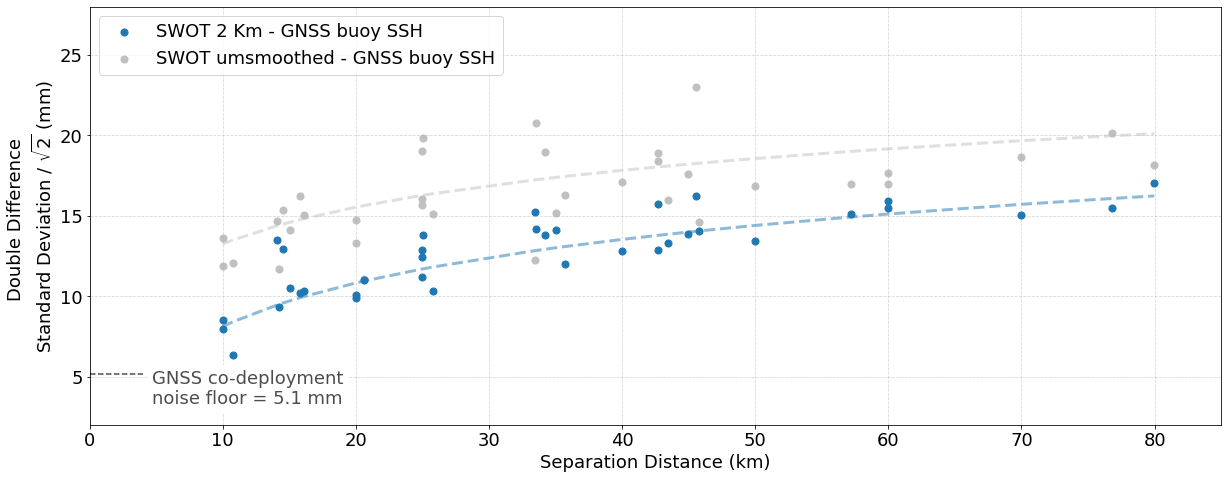

In [43]:
# calculate fit

fig_width = 17.4
plt.rcParams.update({'font.size': 18})

# sort data by distance
sort_idx = np.argsort(distances)
distance_sort = distances[sort_idx]
dd_std_clean_sort = dd_std_clean[sort_idx]
dd_std_us_clean_sort = dd_std_us_clean[sort_idx]
x_data = distance_sort
y_data = dd_std_clean_sort
y_data2 = dd_std_us_clean_sort


# Initial guess for parameters a and b
initial_guess = [1.0, 0.1]

# Fit the model using the robust fitting function
params_fit = robust_fit(x_data, y_data, model, initial_guess)
params_fit2 = robust_fit(x_data, y_data2, model, initial_guess)

# Extract the fitted parameters
a_fit, b_fit = params_fit
a_fit2, b_fit2 = params_fit2

print(f"Fitted parameters: a = {a_fit}, b = {b_fit}")
print(f"Fitted parameters2: a = {a_fit2}, b = {b_fit2}")

fitted_model = model(x_data, *params_fit)
fitted_model_us = model(x_data, *params_fit2)

# Plotting the data and the fitted curve
fig, ax = plt.subplots(1, figsize=(fig_width,7))
plt.scatter(x_data, y_data*10, label='SWOT 2 Km - GNSS buoy SSH', color='C0', s=50, zorder=10)
plt.plot(x_data, fitted_model*10, color='C0', lw=3, alpha=0.5, linestyle='--')
plt.scatter(x_data, y_data2*10, label='SWOT umsmoothed - GNSS buoy SSH', color='silver', s=50, zorder=1)
plt.plot(x_data, fitted_model_us*10,   color='silver', lw=3, alpha=0.5, linestyle='--')
plt.xlabel('Separation Distance (km)')
plt.ylabel("Double Difference \nStandard Deviation / $\sqrt{2}$ (mm)")
ax.grid(linestyle='--', alpha=0.5)
ax.set_ylim(2, 28)
ax.set_xlim(0, 85)

ax.plot([0,4], [5.14, 5.14], c='k', linestyle='--', alpha=0.7)
plt.legend(loc='upper left')

props = dict(facecolor='white',  edgecolor='w')
text = "GNSS co-deployment\nnoise floor = 5.1 mm"
ax.text(0.055, 0.05, text, transform=ax.transAxes, bbox=props, alpha=0.7)

plt.tight_layout()
plt.show()

fig.savefig('/data/hendreya/bass_strait/figures/for_paper/double_differenced_SSH.png', dpi=300, facecolor='w')

In [44]:
print(np.nanmean(y_data[0:3]))
print(np.nanmean(y_data2[0:3]))

0.7603456390122013
1.2513247999054407


In [48]:
print(np.nanmean(y_data[-2:-1]))
print(np.nanmean(y_data2[-2:-1]))

1.546925937222312
2.0160228007403393


Fitted parameters: a = 0.8984827864458302, b = -0.0867418238963663
Fitted parameters2: a = 0.7593886959411846, b = 0.5655186802766965


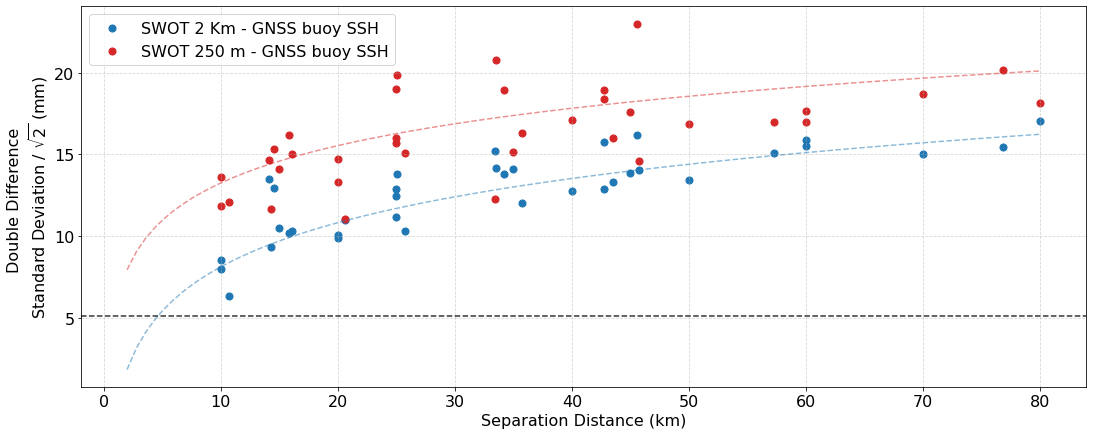

In [190]:
# calculate fit

# sort data by distance
sort_idx = np.argsort(distances)
distance_sort = distances[sort_idx]
dd_std_clean_sort = dd_std_clean[sort_idx]
dd_std_us_clean_sort = dd_std_us_clean[sort_idx]
x_data = distance_sort
y_data = dd_std_clean_sort
y_data2 = dd_std_us_clean_sort


# Initial guess for parameters a and b
initial_guess = [1.0, 0.1]

# Fit the model using the robust fitting function
params_fit = robust_fit(x_data, y_data, model, initial_guess)
params_fit2 = robust_fit(x_data, y_data2, model, initial_guess)

# Extract the fitted parameters
a_fit, b_fit = params_fit
a_fit2, b_fit2 = params_fit2

print(f"Fitted parameters: a = {a_fit}, b = {b_fit}")
print(f"Fitted parameters2: a = {a_fit2}, b = {b_fit2}")

fitted_model = model(np.linspace(2, 80, 100), *params_fit)
fitted_model_us = model(np.linspace(2, 80, 100), *params_fit2)

# Plotting the data and the fitted curve
fig, ax = plt.subplots(1, figsize=(18,7))
plt.scatter(x_data, y_data*10, label='SWOT 2 Km - GNSS buoy SSH', color='C0', s=50)
plt.plot(np.linspace(2, 80, 100), fitted_model*10, color='C0', alpha=0.5, linestyle='--') #label=f'Fitted Model: a*log10(x) + b', 

plt.scatter(x_data, y_data2*10, label='SWOT 250 m - GNSS buoy SSH', color='C3', s=50)
plt.plot(np.linspace(2, 80, 100), fitted_model_us*10,  color='C3', alpha=0.5, linestyle='--')

plt.xlabel('Separation Distance (km)')
plt.ylabel("Double Difference \nStandard Deviation / $\sqrt{2}$ (mm)")
ax.grid(linestyle='--', alpha=0.5)
# ax.set_ylim(6, 25)
plt.legend(loc='upper left')
# props = dict( facecolor='white', alpha=0.5)
# text = "robust fit = a * log10(x) + b"
# ax.text(0.75, 0.1, text, transform=ax.transAxes, bbox=props)
ax.axhline(y=5.14, c='k', linestyle='--', alpha=0.8)
plt.show()

In [194]:
fitted_model_us[0]*10

7.941174561231477

In [9]:
print(np.nanmean(y_data[0:3]))
print(np.nanmean(y_data2[0:3]))

0.7603456390122013
1.2513247999054407


In [10]:
def calc_noise(total, a):
    print('%0.2f mm' % np.sqrt(total**2 - a**2))

In [11]:
calc_noise(7.603, 5.14)
calc_noise(12.51, 5.14)

5.60 mm
11.41 mm


In [ ]:
6.28**2-0.02601565

In [ ]:
0.02601565

In [82]:
np.sqrt((12.5**2-7.6**2)/15)

2.562420730481238

In [83]:
np.sqrt(7.6**2 - 2.56**2)

7.155864727620275

In [36]:
print(fitted_model[0], fitted_model_us[0], fitted_model_us[0] - fitted_model[0])
print(fitted_model[-1], fitted_model_us[-1], fitted_model_us[-1] - fitted_model[-1])

0.7915874366376161 1.2736743907392167 0.48208695410160063
1.5588440417414795 1.991559013725006 0.4327149719835266


In [27]:
print(f"Fitted parameters: a = {a_fit}, b = {b_fit}")
print(f"Fitted parameters2: a = {a_fit2}, b = {b_fit2}")

Fitted parameters: a = 0.9300881222701393, b = -0.09175498531014356
Fitted parameters2: a = 0.8058418559275949, b = 0.4417943933772274


In [87]:
tmp_save = np.vstack((distances, dd_std_clean)).T

np.savetxt('/data/hendreya/bass_strait/data/double_diff_results_2km.csv', tmp_save, delimiter=',')

In [ ]:
############################

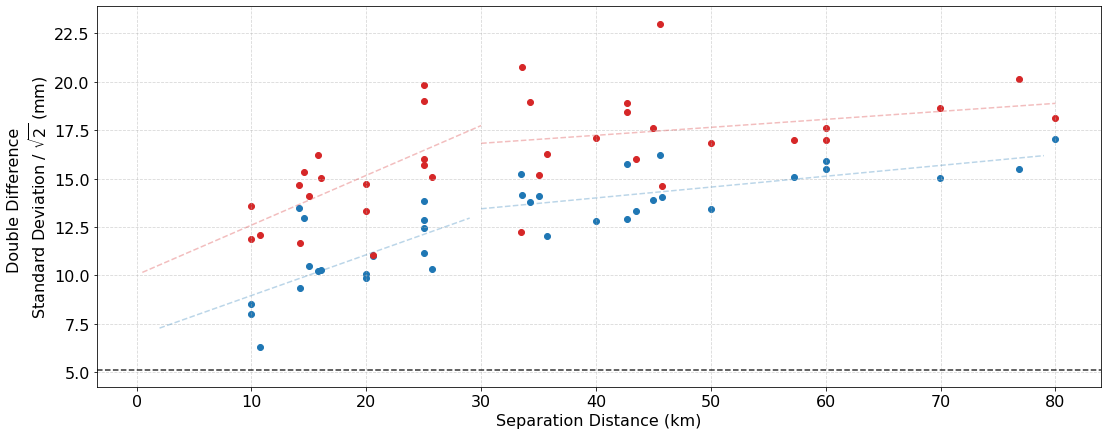

In [195]:
breakpoint = 30

x_data = distance_sort
y_data = dd_std_clean_sort*10
y_data2 = dd_std_us_clean_sort*10

# x_data = np.hstack((0.4, distance_sort))
# y_data = np.hstack((5.14, dd_std_clean_sort*10))
# y_data2 = np.hstack((5.14, dd_std_us_clean_sort*10))

y_data_a = y_data[x_data<=breakpoint]
y_data_b = y_data[x_data>breakpoint]

x_data_a = x_data[x_data<=breakpoint]
x_data_b = x_data[x_data>breakpoint]


coef_a = np.polyfit(x_data_a, y_data_a, 1)
fit_line_a = np.poly1d(coef_a)
theil_slope, intercept, _, _ = stats.theilslopes(y_data_a, x_data_a, 0.95)
theil_fit_a = slope * range(2,breakpoint) + intercept

coef_b = np.polyfit(x_data_b, y_data_b, 1)
fit_line_b = np.poly1d(coef_b)
theil_slope, intercept, _, _ = stats.theilslopes(y_data_b, x_data_b, 0.95)
theil_fit_b = theil_slope * range(breakpoint,80) + intercept


y_data2_a = y_data2[x_data<=breakpoint]
y_data2_b = y_data2[x_data>breakpoint]


coef2_a = np.polyfit(x_data_a, y_data2_a, 1)
fit_line2_a = np.poly1d(coef2_a)
theil_slope, intercept, _, _ = stats.theilslopes(y_data2_a, x_data_a, 0.95)
theil_fit2_a = theil_slope * np.linspace(0.5, breakpoint, 10) + intercept

coef2_b = np.polyfit(x_data_b, y_data2_b, 1)
fit_line2_b = np.poly1d(coef2_b)
theil_slope, intercept, _, _ = stats.theilslopes(y_data2_b, x_data_b, 0.95)
theil_fit2_b = theil_slope * range(breakpoint,80) + intercept




# Plotting the data and the fitted curve
fig, ax = plt.subplots(1, figsize=(18,7))

plt.scatter(x_data_a, y_data_a, c='C0')
plt.scatter(x_data_b, y_data_b, c='C0')
plt.scatter(x_data_a, y_data2_a, c='C3')
plt.scatter(x_data_b, y_data2_b, c='C3')

plt.plot(range(2,breakpoint), fit_line_a(range(2,breakpoint)), linestyle='--', c='C0', alpha=0.3)
plt.plot(range(breakpoint,80), fit_line_b(range(breakpoint,80)), linestyle='--', c='C0', alpha=0.3)
plt.plot(np.linspace(0.5, breakpoint, 10), fit_line2_a(np.linspace(0.5, breakpoint, 10)), linestyle='--', c='C3', alpha=0.3)
plt.plot(np.linspace(breakpoint,80,10), fit_line2_b(np.linspace(breakpoint,80,10)), linestyle='--', c='C3', alpha=0.3)

# plt.plot(range(2,breakpoint), theil_fit_a, linestyle='--', c='grey', alpha=0.5)
# plt.plot(range(breakpoint,80), theil_fit_b, linestyle='--', c='grey', alpha=0.5)
# plt.plot(np.linspace(0.5, breakpoint, 10), theil_fit2_a, linestyle='--', c='grey', alpha=0.5)
# plt.plot(range(breakpoint,80), theil_fit2_b, linestyle='--', c='grey', alpha=0.5)


ax.axhline(y=5.14, c='k', linestyle='--', alpha=0.8)

plt.xlabel('Separation Distance (km)')
plt.ylabel("Double Difference \nStandard Deviation / $\sqrt{2}$ (mm)")
ax.grid(linestyle='--', alpha=0.5)
# ax.set_ylim(6, 25)
# plt.legend(loc='upper left')
# props = dict( facecolor='white', alpha=0.5)
# text = "robust fit = a * log10(x) + b"
# ax.text(0.75, 0.1, text, transform=ax.transAxes, bbox=props)

plt.show()

In [196]:
np.sqrt((11.4**2-7.6**2)/15)

2.193931022920578

In [197]:
np.sqrt((11.4**2-7.6**2)/15) * 4

8.775724091682312

In [198]:
np.sqrt(7.6**2 - 2.19**2)

7.277630108764803

In [ ]:
np.sqrt(11.4**2 - 8.77**2)

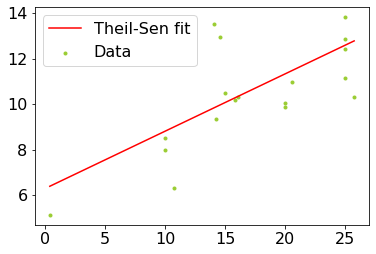

In [152]:
from scipy import stats

slope, intercept, _, _ = stats.theilslopes(y_data_a, x_data_a, 0.95)

# Predict the values using the estimated slope and intercept
y_pred = slope * x_data_a + intercept

# Plot the results
plt.scatter(x_data_a, y_data_a, color='yellowgreen', marker='.', label='Data')
plt.plot(x_data_a, y_pred, color='red', label='Theil-Sen fit')
plt.legend()
plt.show()

In [140]:
np.linspace(0.5,80, 10)

array([ 0.5       ,  9.33333333, 18.16666667, 27.        , 35.83333333, 44.66666667, 53.5       ,
       62.33333333, 71.16666667, 80.        ])

In [143]:
print(fit_line_a(2))
print(fit_line2_a(0.5))

6.615657858422651
8.164591368264835


In [144]:
np.sqrt((11.4**2-7.6**2)/3)

4.905778905196062

In [149]:
11.4**2

129.96

In [150]:
5.8**2 + (4*4.91)**2

419.3696

In [145]:
np.sqrt((11.4**2-7.6**2)/5)

3.8000000000000003

In [147]:
3.8*6

22.799999999999997

In [146]:
np.sqrt(7.6**2 - 3.8**2)

6.581793068761733

In [ ]:
# calculate fit

# sort data by distance
sort_idx = np.argsort(distances)
distance_sort = distances[sort_idx]
dd_std_clean_sort = dd_std_clean[sort_idx]
dd_std_us_clean_sort = dd_std_us_clean[sort_idx]




# Initial guess for parameters a and b
initial_guess = [1.0, 0.1]

# Fit the model using the robust fitting function
params_fit = robust_fit(x_data, y_data, model, initial_guess)
params_fit2 = robust_fit(x_data, y_data2, model, initial_guess)

# Extract the fitted parameters
a_fit, b_fit = params_fit
a_fit2, b_fit2 = params_fit2

print(f"Fitted parameters: a = {a_fit}, b = {b_fit}")
print(f"Fitted parameters2: a = {a_fit2}, b = {b_fit2}")

fitted_model = model(x_data, *params_fit)
fitted_model_us = model(x_data, *params_fit2)

# Plotting the data and the fitted curve
fig, ax = plt.subplots(1, figsize=(18,7))
plt.scatter(x_data, y_data*10, label='SWOT 2 Km - GNSS buoy SSH', color='C0', s=50)
plt.plot(x_data, fitted_model*10, color='C0') #label=f'Fitted Model: a*log10(x) + b', 
plt.scatter(x_data, y_data2*10, label='SWOT 250 m - GNSS buoy SSH', color='C3', s=50)
plt.plot(x_data, fitted_model_us*10,  color='C3')
plt.xlabel('Separation Distance (km)')
plt.ylabel("Double Difference \nStandard Deviation / $\sqrt{2}$ (mm)")
ax.grid(linestyle='--', alpha=0.5)
ax.set_ylim(6, 25)
plt.legend(loc='upper left')
props = dict( facecolor='white', alpha=0.5)
text = "robust fit = a * log10(x) + b"
ax.text(0.75, 0.1, text, transform=ax.transAxes, bbox=props)
plt.show()

In [12]:

xdata

array([ 0.        ,  9.98028357, 10.00017407, 10.73932428, 14.10225563, 14.25438334, 14.54428033,
       15.01865692, 15.80191677, 16.08587283, 19.98045643, 19.98545114, 20.58568132, 24.98326456,
       24.9935692 , 24.99894013, 25.01528803, 25.75792687, 33.44334682, 33.54503772, 34.23976434,
       34.99911335, 35.7381948 , 40.01222561, 42.69950369, 42.72434162, 43.48128314, 44.97901212,
       45.57552777, 45.73836633, 49.99250795, 57.22202065, 59.99268175, 59.99766475, 69.97794402,
       76.78894197, 79.97811797])

In [15]:
dd_std_clean_sort

array([0.79855207, 0.85140746, 0.63107739, 1.3501624 , 0.93559707, 1.29580839, 1.04818129,
       1.02048249, 1.02974854, 0.98571611, 1.00695217, 1.09959818, 1.28698017, 1.11668099,
       1.24383016, 1.38187787, 1.03229768, 1.52172285, 1.41703935, 1.37716743, 1.40945811,
       1.20197558, 1.27837677, 1.29005455, 1.57456041, 1.33244338, 1.38750429, 1.62146071,
       1.40724131, 1.34132838, 1.50824372, 1.54869748, 1.59110357, 1.50152267, 1.54692594,
       1.70341717])

In [18]:
np.linspace(0.4, 80, 100)

array([ 0.4       ,  1.2040404 ,  2.00808081,  2.81212121,  3.61616162,  4.42020202,  5.22424242,
        6.02828283,  6.83232323,  7.63636364,  8.44040404,  9.24444444, 10.04848485, 10.85252525,
       11.65656566, 12.46060606, 13.26464646, 14.06868687, 14.87272727, 15.67676768, 16.48080808,
       17.28484848, 18.08888889, 18.89292929, 19.6969697 , 20.5010101 , 21.30505051, 22.10909091,
       22.91313131, 23.71717172, 24.52121212, 25.32525253, 26.12929293, 26.93333333, 27.73737374,
       28.54141414, 29.34545455, 30.14949495, 30.95353535, 31.75757576, 32.56161616, 33.36565657,
       34.16969697, 34.97373737, 35.77777778, 36.58181818, 37.38585859, 38.18989899, 38.99393939,
       39.7979798 , 40.6020202 , 41.40606061, 42.21010101, 43.01414141, 43.81818182, 44.62222222,
       45.42626263, 46.23030303, 47.03434343, 47.83838384, 48.64242424, 49.44646465, 50.25050505,
       51.05454545, 51.85858586, 52.66262626, 53.46666667, 54.27070707, 55.07474747, 55.87878788,
       56.68282828, 

Fitted parameters: a = 0.5766752893546363, b = 0.4283585304445271
Fitted parameters2: a = 0.6845185986062006, b = 0.6375654160728346


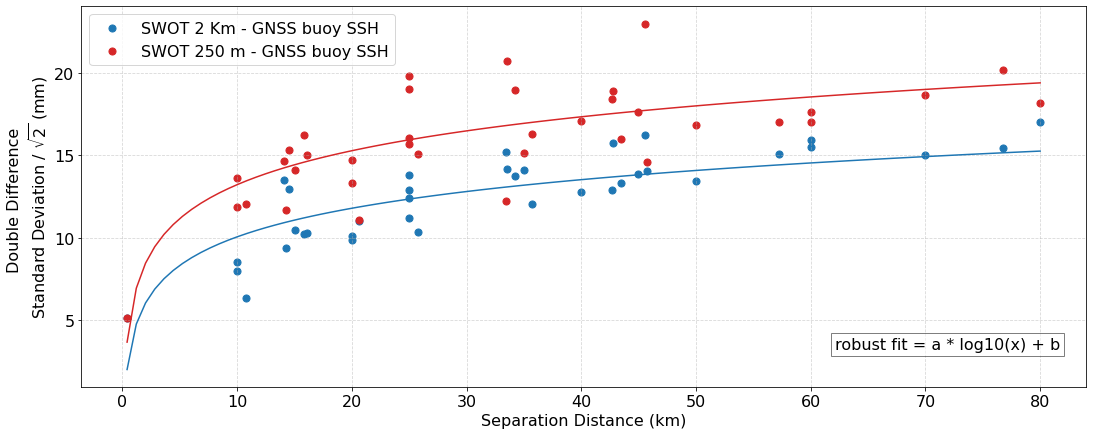

In [23]:
# calculate fit

# sort data by distance
sort_idx = np.argsort(distances)
distance_sort = distances[sort_idx]
dd_std_clean_sort = dd_std_clean[sort_idx]
dd_std_us_clean_sort = dd_std_us_clean[sort_idx]
x_data = np.hstack((0.4, distance_sort))
y_data = np.hstack((0.514, dd_std_clean_sort))
y_data2 = np.hstack((0.514, dd_std_us_clean_sort))

x_fit = np.linspace(0.4, 80, 100)


# Initial guess for parameters a and b
initial_guess = [1.0, 0.1]

# Fit the model using the robust fitting function
params_fit = robust_fit(x_data, y_data, model, initial_guess)
params_fit2 = robust_fit(x_data, y_data2, model, initial_guess)

# Extract the fitted parameters
a_fit, b_fit = params_fit
a_fit2, b_fit2 = params_fit2

print(f"Fitted parameters: a = {a_fit}, b = {b_fit}")
print(f"Fitted parameters2: a = {a_fit2}, b = {b_fit2}")

fitted_model = model(x_fit, *params_fit)
fitted_model_us = model(x_fit, *params_fit2)



# Plotting the data and the fitted curve
fig, ax = plt.subplots(1, figsize=(18,7))
plt.scatter(x_data, y_data*10, label='SWOT 2 Km - GNSS buoy SSH', color='C0', s=50)
plt.plot(x_fit, fitted_model*10, color='C0') #label=f'Fitted Model: a*log10(x) + b', 
plt.scatter(x_data, y_data2*10, label='SWOT 250 m - GNSS buoy SSH', color='C3', s=50)
plt.plot(x_fit, fitted_model_us*10,  color='C3')
plt.xlabel('Separation Distance (km)')
plt.ylabel("Double Difference \nStandard Deviation / $\sqrt{2}$ (mm)")
ax.grid(linestyle='--', alpha=0.5)
# ax.set_ylim(6, 25)
plt.legend(loc='upper left')
props = dict( facecolor='white', alpha=0.5)
text = "robust fit = a * log10(x) + b"
ax.text(0.75, 0.1, text, transform=ax.transAxes, bbox=props)
plt.show()

In [63]:
x_tmp = np.array((0.4, 10, 20, 30, 40, 50, 60, 70 , 80))

In [58]:
x_tmp = np.array((0.4, 
                  np.nanmean(distance_sort[0:3]), 
                  np.nanmean(distance_sort[3:15]), 
                  np.nanmean(distance_sort[15:21]), 
                  np.nanmean(distance_sort[21:27]), 
                  np.nanmean(distance_sort[27:30]), 
                  np.nanmean(distance_sort[30:33]), 
                  np.nanmean(distance_sort[33]), 
                  np.nanmean(distance_sort[34:36])))

In [59]:
tmp = np.array((0.514, np.nanmean(dd_std_clean_sort[0:3]), 
          np.nanmean(dd_std_clean_sort[3:15]), 
          np.nanmean(dd_std_clean_sort[15:21]),
          np.nanmean(dd_std_clean_sort[21:27]), 
          np.nanmean(dd_std_clean_sort[27:30]), 
          np.nanmean(dd_std_clean_sort[30:33]),
          np.nanmean(dd_std_clean_sort[33]),
          np.nanmean(dd_std_clean_sort[34:36])))

tmp_us = np.array((0.514, np.nanmean(dd_std_us_clean_sort[0:3]), 
          np.nanmean(dd_std_us_clean_sort[3:15]), 
          np.nanmean(dd_std_us_clean_sort[15:21]),
          np.nanmean(dd_std_us_clean_sort[21:27]), 
          np.nanmean(dd_std_us_clean_sort[27:30]), 
          np.nanmean(dd_std_us_clean_sort[30:33]),
          np.nanmean(dd_std_us_clean_sort[33]),
          np.nanmean(dd_std_us_clean_sort[34:36])))

In [55]:
x_tmp = np.array((0, 
                  np.nanmean(distance_sort[0:3]), 
                  np.nanmean(distance_sort[3:6]), 
                  np.nanmean(distance_sort[6:9]), 
                  np.nanmean(distance_sort[9:12]), 
                  np.nanmean(distance_sort[12:15]), 
                  np.nanmean(distance_sort[15:18]), 
                  np.nanmean(distance_sort[18:21]), 
                  np.nanmean(distance_sort[21:24]), 
                  np.nanmean(distance_sort[24:27]), 
                  np.nanmean(distance_sort[27:30]), 
                  np.nanmean(distance_sort[30:33]), 
                  np.nanmean(distance_sort[33:36])))
            

In [56]:
tmp = np.array((0.514, np.nanmean(dd_std_clean_sort[0:3]), 
          np.nanmean(dd_std_clean_sort[3:6]), 
          np.nanmean(dd_std_clean_sort[6:9]),
          np.nanmean(dd_std_clean_sort[9:12]), 
          np.nanmean(dd_std_clean_sort[12:15]), 
          np.nanmean(dd_std_clean_sort[15:18]),
          np.nanmean(dd_std_clean_sort[18:21]),
          np.nanmean(dd_std_clean_sort[21:24]),
            np.nanmean(dd_std_clean_sort[24:27]),
                np.nanmean(dd_std_clean_sort[27:30]), 
                np.nanmean(dd_std_clean_sort[30:33]), 
                np.nanmean(dd_std_clean_sort[33:36])))

tmp_us = np.array((0.514, np.nanmean(dd_std_us_clean_sort[0:3]), 
          np.nanmean(dd_std_us_clean_sort[3:6]), 
          np.nanmean(dd_std_us_clean_sort[6:9]),
          np.nanmean(dd_std_us_clean_sort[9:12]), 
          np.nanmean(dd_std_us_clean_sort[12:15]), 
          np.nanmean(dd_std_us_clean_sort[15:18]),
          np.nanmean(dd_std_us_clean_sort[18:21]),
          np.nanmean(dd_std_us_clean_sort[21:24]),
            np.nanmean(dd_std_us_clean_sort[24:27]),
                np.nanmean(dd_std_us_clean_sort[27:30]), 
                np.nanmean(dd_std_us_clean_sort[30:33]), 
                np.nanmean(dd_std_us_clean_sort[33:36])))

In [41]:
print(distance_sort[0:6])
print(distance_sort[6:15])
print(distance_sort[15:21])
print(distance_sort[21:27])
print(distance_sort[27:30])
print(distance_sort[30:33])
print(distance_sort[33])
print(distance_sort[34:36])

[ 9.98028357 10.00017407 10.73932428 14.10225563 14.25438334 14.54428033]
[15.01865692 15.80191677 16.08587283 19.98045643 19.98545114 20.58568132 24.98326456 24.9935692
 24.99894013]
[25.01528803 25.75792687 33.44334682 33.54503772 34.23976434 34.99911335]
[35.7381948  40.01222561 42.69950369 42.72434162 43.48128314 44.97901212]
[45.57552777 45.73836633 49.99250795]
[57.22202065 59.99268175 59.99766475]
69.97794402395517
[76.78894197 79.97811797]


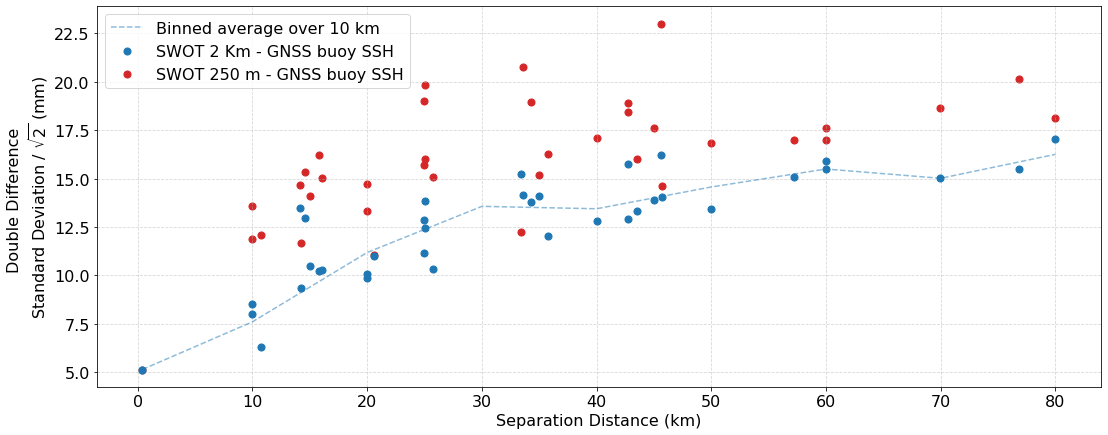

In [86]:
# Plotting the data and the fitted curve
fig, ax = plt.subplots(1, figsize=(18,7))
plt.scatter(x_data, y_data*10, label='SWOT 2 Km - GNSS buoy SSH', color='C0', s=50, zorder=10)
# plt.plot(x_fit, fitted_model*10, color='C0') #label=f'Fitted Model: a*log10(x) + b', 
plt.plot(x_tmp, tmp*10, c='C0', linestyle='--', alpha=0.5, label='Binned average over 10 km')
plt.scatter(x_data, y_data2*10, label='SWOT 250 m - GNSS buoy SSH', color='C3', s=50, zorder=1)
# plt.plot(x_fit, fitted_model_us*10,  color='C3')
# plt.plot(x_tmp, tmp_us*10, c='C3', linestyle='--', alpha=0.5, label='Binned average over 10 km')
plt.xlabel('Separation Distance (km)')
plt.ylabel("Double Difference \nStandard Deviation / $\sqrt{2}$ (mm)")
ax.grid(linestyle='--', alpha=0.5)
# ax.set_ylim(6, 25)
plt.legend(loc='upper left')

plt.show()

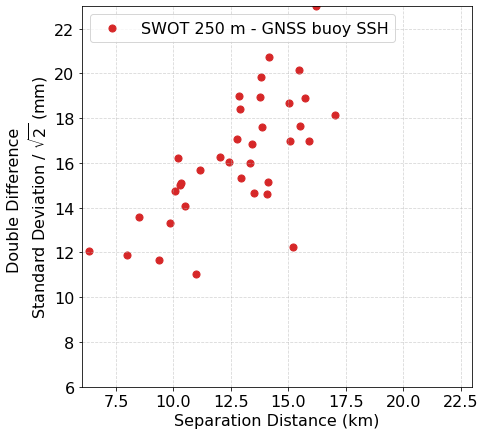

In [75]:
fig, ax = plt.subplots(1, figsize=(7,7))
# plt.scatter(x_data, y_data*10, label='SWOT 2 Km - GNSS buoy SSH', color='C0', s=50, zorder=10)
# plt.plot(x_fit, fitted_model*10, color='C0') #label=f'Fitted Model: a*log10(x) + b', 
# plt.plot(x_tmp, tmp*10, c='C0', linestyle='--', alpha=0.5, label='Binned average over 10 km')
plt.scatter(y_data*10, y_data2*10, label='SWOT 250 m - GNSS buoy SSH', color='C3', s=50, zorder=1)
# plt.plot(x_fit, fitted_model_us*10,  color='C3')
# plt.plot(x_tmp, tmp_us*10, c='C3', linestyle='--', alpha=0.5, label='Binned average over 10 km')
plt.xlabel('Separation Distance (km)')
plt.ylabel("Double Difference \nStandard Deviation / $\sqrt{2}$ (mm)")
ax.grid(linestyle='--', alpha=0.5)
# ax.set_ylim(6, 25)
plt.legend(loc='upper left')
ax.set_xlim(6, 23)
ax.set_ylim(6, 23)



plt.show()

In [92]:
np.sqrt((20**2 - 7.6**2)/15)

4.776609676329017

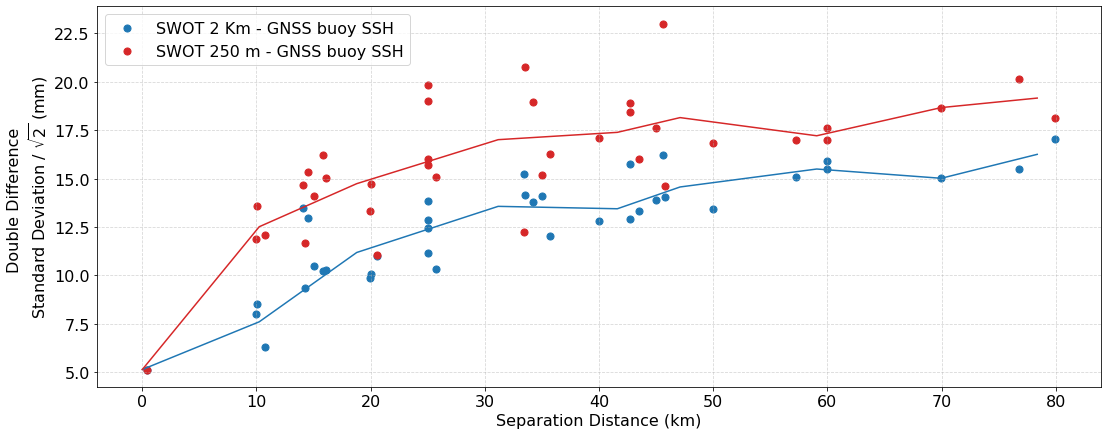

In [60]:
# Plotting the data and the fitted curve
fig, ax = plt.subplots(1, figsize=(18,7))
plt.scatter(x_data, y_data*10, label='SWOT 2 Km - GNSS buoy SSH', color='C0', s=50)
# plt.plot(x_fit, fitted_model*10, color='C0') #label=f'Fitted Model: a*log10(x) + b', 
plt.plot(x_tmp, tmp*10, c='C0')
plt.scatter(x_data, y_data2*10, label='SWOT 250 m - GNSS buoy SSH', color='C3', s=50)
# plt.plot(x_fit, fitted_model_us*10,  color='C3')
plt.plot(x_tmp, tmp_us*10, c='C3')
plt.xlabel('Separation Distance (km)')
plt.ylabel("Double Difference \nStandard Deviation / $\sqrt{2}$ (mm)")
ax.grid(linestyle='--', alpha=0.5)
# ax.set_ylim(6, 25)
plt.legend(loc='upper left')

plt.show()

In [ ]:
print(distance_sort[0:6])
print(distance_sort[6:15])
print(distance_sort[15:21])
print(distance_sort[21:27])
print(distance_sort[27:30])
print(distance_sort[30:33])
print(distance_sort[33])
print(distance_sort[34:36])

In [83]:
dd_std_clean

array([1.00409505, 1.28303112, 1.36312613, 1.4331058 , 1.37724036, 1.83893347, 1.29434496,
       1.49474304, 0.8626317 , 1.12006807, 1.29122422, 1.30989554, 1.71070622, 1.10729385,
       1.49252707, 0.73688989, 0.97721828, 1.09910321, 1.73300823, 0.94727668, 1.23261188,
       1.046593  , 1.19723565, 1.51464375, 0.87867939, 1.49434606, 0.76769984, 1.06530271,
       1.34134833, 1.07099718, 0.74645724, 1.30959583, 1.1076521 , 1.55307236, 1.3329579 ,
       1.68860805])

In [60]:
np.nanmax(dd_std_clean)

1.8389334654173983

In [53]:
np.sqrt(5**2+5.5**2+17**2)

18.553975315279473

In [38]:
np.sqrt(5**2+2**2+11.3**2)

12.51758762701504

In [58]:
np.sqrt(5.1**2+5.5**2)

7.500666637039671

In [59]:
np.sqrt(5.1**2+11.5**2)

12.580143083447023

In [76]:
np.sqrt(5.1**2+5.5**2+50**2)

50.55946993393028

In [79]:
np.sqrt(5.1**2+11.5**2+50**2)

51.55831649695324

In [35]:
11.5*(1/2)

5.75

In [46]:
print(np.nanmin(dd_std_clean))
print(np.nanmax(dd_std_clean))

0.7368898887269086
1.8389334654173983


In [66]:
np.nanmean(dd_std_clean[distances<11])

0.7503489905605987

In [68]:
np.sqrt(5.1**2+5.5**2)

7.500666637039671

In [22]:
1/np.sqrt(64)

0.125

In [27]:
11.4*(1/np.sqrt(4))

5.7

In [32]:
54*(1/np.sqrt(64))

6.75

In [95]:
####################################################

# wn = [1/1000, 1/15]
# pw = [2, 2]

# np.trapz(pw, wn)

# f_1 = np.linspace(1/1000, 1/15, 10000)
# error_1 = 2 + f_1*0
# area = np.trapz(error_1, f_1)
# print('error budget: %0.2f cm' % np.sqrt(area))

# wn = [0, 1/15]
# pw = [0.2, 0.2]

# np.trapz(pw, wn)

# np.sqrt(2)

# np.sqrt(0.3)